In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization, Conv2D, MaxPooling2D, RandomHeight, RandomWidth, RandomZoom, RandomRotation, RandomFlip
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img, image_dataset_from_directory
from tensorflow.keras.applications.mobilenet import preprocess_input

import matplotlib.pyplot as plt
import os
import imghdr

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from PIL import Image
from wordcloud import WordCloud


C:\Users\kpegg\AppData\Local\Temp\ipykernel_26764\42254409.py:13: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [3]:
train = "../data/dog-breed-identification/train"
test = "../data/dog-breed-identification/test"
df=pd.read_csv("../data/dog-breed-identification/labels.csv")
df.describe()

id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126

In [4]:
df.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

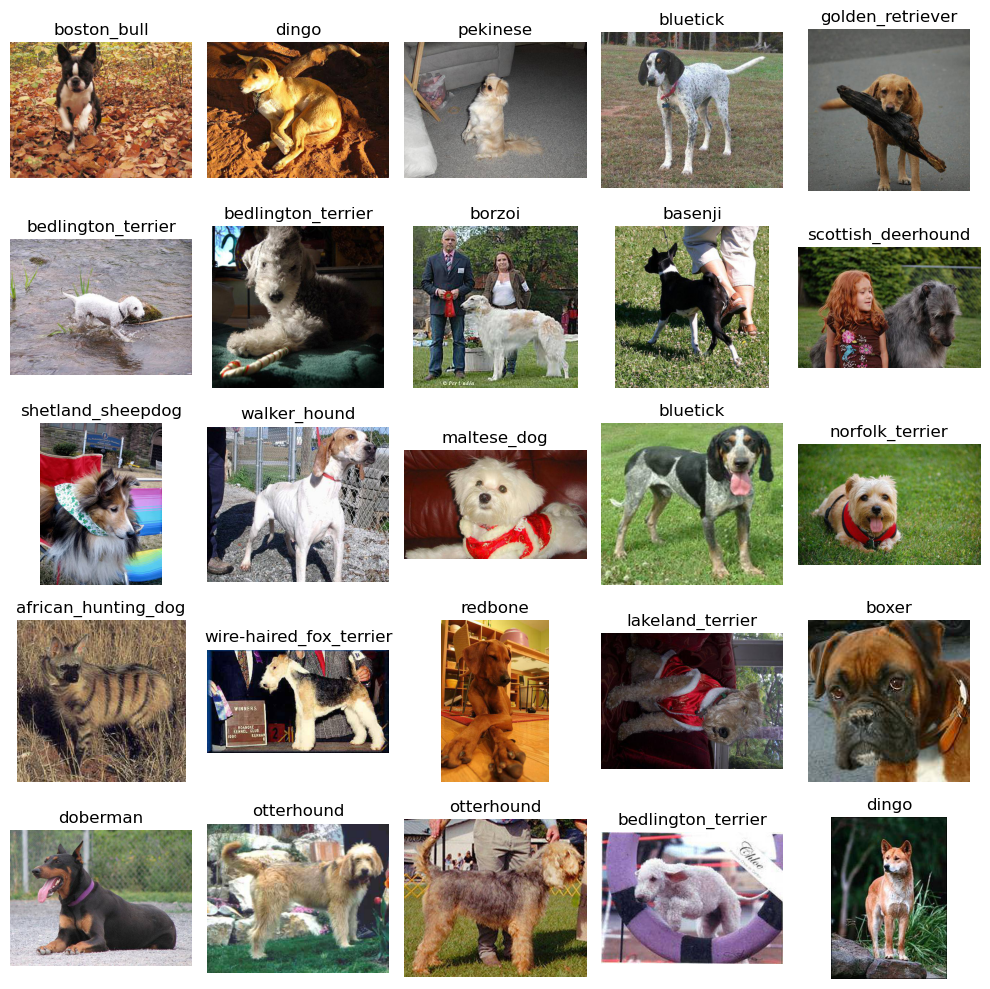

In [5]:
# show some labels with corresponding photos

nrow = 5
ncol = 5
fig, ax = plt.subplots(nrow, ncol, figsize=(10, 10))

for i, (img_id, breed) in enumerate(df[["id", "breed"]].values[:nrow * ncol]):
    image_path = os.path.join(train, img_id + ".jpg")
    
    # Use PIL to open and convert the image
    image = Image.open(image_path)
    
    # Convert to RGB if the image is not already in RGB mode
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    row = i // ncol
    col = i % ncol
    
    ax[row, col].imshow(image)
    ax[row, col].set_title(breed)
    ax[row, col].axis("off")

plt.tight_layout()
plt.show()

In [6]:
print("Number of unique dog breeds: ", len(df.breed.unique()))

Number of unique dog breeds:  120


In [7]:
labels = df["breed"].unique().tolist()
print(labels)

['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever', 'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound', 'shetland_sheepdog', 'walker_hound', 'maltese_dog', 'norfolk_terrier', 'african_hunting_dog', 'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer', 'doberman', 'otterhound', 'standard_schnauzer', 'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn', 'affenpinscher', 'labrador_retriever', 'ibizan_hound', 'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael', 'dhole', 'toy_poodle', 'border_terrier', 'tibetan_terrier', 'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz', 'german_shepherd', 'greater_swiss_mountain_dog', 'basset', 'australian_terrier', 'schipperke', 'rhodesian_ridgeback', 'irish_setter', 'appenzeller', 'bloodhound', 'samoyed', 'miniature_schnauzer', 'brittany_spaniel', 'kelpie', 'papillon', 'border_collie', 'entlebucher', 'collie', 'malamute', 'welsh_springer_spaniel', 'chihuahua', 'saluki', 'pug', 'malino

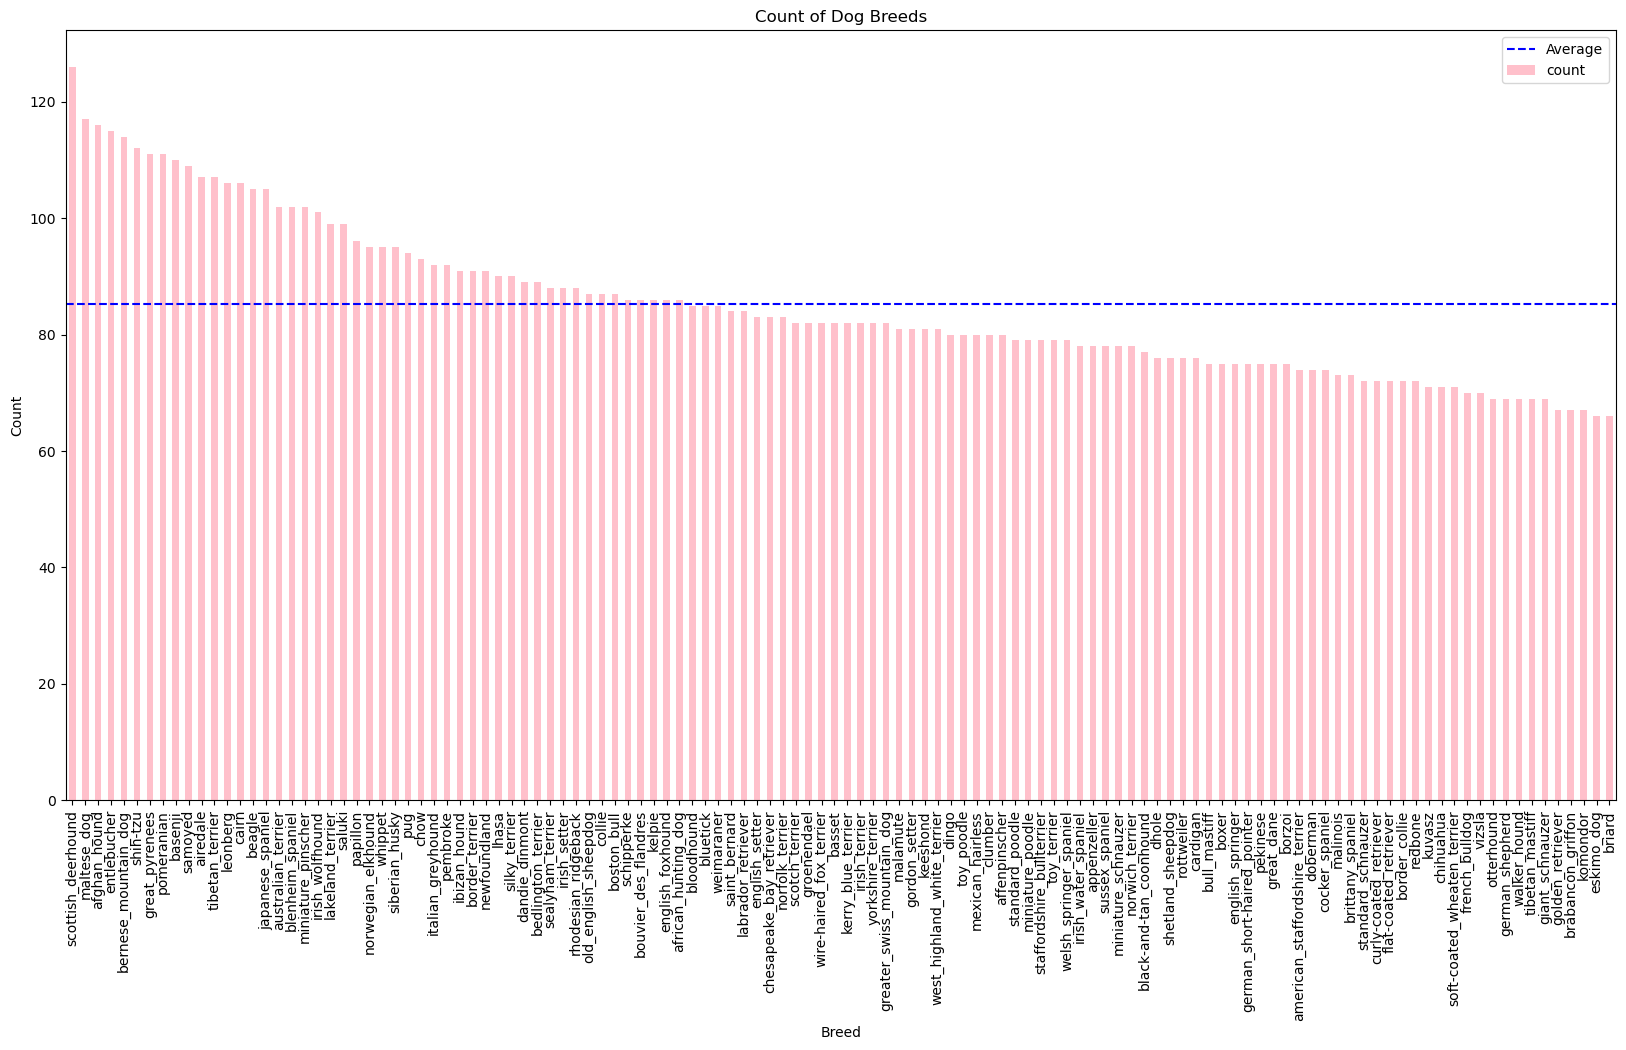

In [8]:
# Plot the bar chart of filname count per breed
ax = df["breed"].value_counts().plot.bar(figsize=(20, 10), color='pink')

# calculate the average value
average_value = df["breed"].value_counts().mean()

# add the average line
ax.axhline(average_value, color='blue', linestyle='--', label='Average')

# Customize the plot as desired
plt.xlabel('Breed')
plt.ylabel('Count')
plt.title('Count of Dog Breeds')
plt.legend();

In [9]:
# add '.jpg' to id for image_id
df['image_file'] = df['id'].apply(lambda x: x + ".jpg")
df.head()

id             breed  \
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull   
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo   
2  001cdf01b096e06d78e9e5112d419397          pekinese   
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick   
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever   

                             image_file  
0  000bec180eb18c7604dcecc8fe0dba07.jpg  
1  001513dfcb2ffafc82cccf4d8bbaba97.jpg  
2  001cdf01b096e06d78e9e5112d419397.jpg  
3  00214f311d5d2247d5dfe4fe24b2303d.jpg  
4  0021f9ceb3235effd7fcde7f7538ed62.jpg

In [10]:
# converting images to numpy array
image_size = 100  # Adjust to your desired image size

train_data = np.zeros((len(df), image_size, image_size, 3), dtype="float32")

for i, img_id in enumerate(df["image_file"]):
    img_path = os.path.join(train, img_id)
    img = Image.open(img_path)
    
    # Resize the image
    img = img.resize((image_size, image_size))
    
    # Convert to array with preprocessing
    img_array = np.array(img)/255
    
    # Convert to array and preprocess
    #img_array = preprocess_input(np.expand_dims(np.array(img), axis=0))
    
    train_data[i] = img_array

In [11]:
train_data[i]

array([[[0.73333335, 0.73333335, 0.7411765 ],
        [0.7176471 , 0.7176471 , 0.7254902 ],
        [0.73333335, 0.73333335, 0.7411765 ],
        ...,
        [0.41568628, 0.40784314, 0.4117647 ],
        [0.3372549 , 0.32941177, 0.33333334],
        [0.3372549 , 0.33333334, 0.33333334]],

       [[0.72156864, 0.72156864, 0.7294118 ],
        [0.6745098 , 0.6745098 , 0.68235296],
        [0.6627451 , 0.6627451 , 0.67058825],
        ...,
        [0.35686275, 0.34901962, 0.3529412 ],
        [0.35686275, 0.34901962, 0.3529412 ],
        [0.3529412 , 0.34901962, 0.3529412 ]],

       [[0.6901961 , 0.6901961 , 0.69803923],
        [0.69411767, 0.69411767, 0.7019608 ],
        [0.6313726 , 0.6313726 , 0.6392157 ],
        ...,
        [0.42352942, 0.41568628, 0.41568628],
        [0.34901962, 0.34117648, 0.34509805],
        [0.5176471 , 0.5137255 , 0.5254902 ]],

       ...,

       [[0.8117647 , 0.8117647 , 0.8117647 ],
        [0.8509804 , 0.8509804 , 0.8509804 ],
        [0.84705883, 0

In [12]:
train_data.shape

(10222, 100, 100, 3)

In [13]:
train_data[0]

array([[[0.5921569 , 0.39215687, 0.21960784],
        [0.76862746, 0.6156863 , 0.40392157],
        [0.6392157 , 0.47843137, 0.23137255],
        ...,
        [0.87058824, 0.76862746, 0.3372549 ],
        [0.8627451 , 0.7411765 , 0.40784314],
        [0.8       , 0.6784314 , 0.31764707]],

       [[0.5294118 , 0.3764706 , 0.23529412],
        [0.6784314 , 0.5372549 , 0.38039216],
        [0.5764706 , 0.40392157, 0.25882354],
        ...,
        [0.8156863 , 0.6431373 , 0.24313726],
        [0.7607843 , 0.6       , 0.3137255 ],
        [0.8509804 , 0.70980394, 0.3137255 ]],

       [[0.69803923, 0.4862745 , 0.23921569],
        [0.6431373 , 0.41960785, 0.1764706 ],
        [0.63529414, 0.4       , 0.23529412],
        ...,
        [0.79607844, 0.54901963, 0.14901961],
        [0.83137256, 0.65882355, 0.33333334],
        [0.8       , 0.6392157 , 0.30980393]],

       ...,

       [[0.7411765 , 0.4745098 , 0.30588236],
        [0.7490196 , 0.5137255 , 0.2901961 ],
        [0.62352943, 0

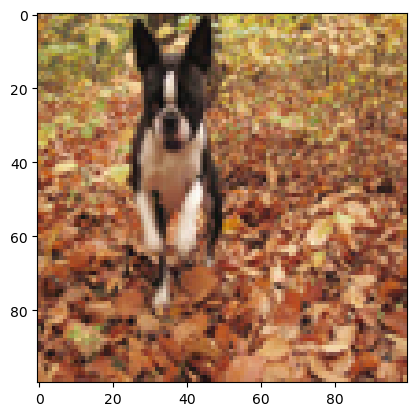

In [14]:
plt.imshow(train_data[0])

In [15]:
# instantiate LabelEncoder
encoder = LabelEncoder()

# fit & transform encoder on to label_data
label_data = encoder.fit_transform(df["breed"].values)

In [16]:
label_data.shape

(10222,)

In [17]:
train_data

array([[[[0.5921569 , 0.39215687, 0.21960784],
         [0.76862746, 0.6156863 , 0.40392157],
         [0.6392157 , 0.47843137, 0.23137255],
         ...,
         [0.87058824, 0.76862746, 0.3372549 ],
         [0.8627451 , 0.7411765 , 0.40784314],
         [0.8       , 0.6784314 , 0.31764707]],

        [[0.5294118 , 0.3764706 , 0.23529412],
         [0.6784314 , 0.5372549 , 0.38039216],
         [0.5764706 , 0.40392157, 0.25882354],
         ...,
         [0.8156863 , 0.6431373 , 0.24313726],
         [0.7607843 , 0.6       , 0.3137255 ],
         [0.8509804 , 0.70980394, 0.3137255 ]],

        [[0.69803923, 0.4862745 , 0.23921569],
         [0.6431373 , 0.41960785, 0.1764706 ],
         [0.63529414, 0.4       , 0.23529412],
         ...,
         [0.79607844, 0.54901963, 0.14901961],
         [0.83137256, 0.65882355, 0.33333334],
         [0.8       , 0.6392157 , 0.30980393]],

        ...,

        [[0.7411765 , 0.4745098 , 0.30588236],
         [0.7490196 , 0.5137255 , 0.2901961 ]

In [18]:
X = train_data
y = label_data

# # split into training & validation sets
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y, 
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(8177, 8177, 2045, 2045)

In [19]:
# Create a Sequential model
base_model = Sequential()

# Add Convolutional layers
base_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
base_model.add(MaxPooling2D((2, 2)))

base_model.add(Conv2D(64, (3, 3), activation='relu'))
base_model.add(MaxPooling2D((2, 2)))

base_model.add(Conv2D(128, (3, 3), activation='relu'))
base_model.add(MaxPooling2D((2, 2)))

# Flatten the output and add Dense layers for classification
base_model.add(Flatten())
base_model.add(Dense(128, activation='relu'))
base_model.add(Dense(120, activation='softmax'))  # Assuming 10 output classes

# Compile the model
base_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 128)       0

In [21]:
first = base_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=64)

Epoch 1/20


128/128 [==============================] - 47s 359ms/step - loss: 4.7823 - accuracy: 0.0110 - val_loss: 4.7586 - val_accuracy: 0.0142
Epoch 2/20
128/128 [==============================] - 46s 362ms/step - loss: 4.6452 - accuracy: 0.0224 - val_loss: 4.5531 - val_accuracy: 0.0269
Epoch 3/20
128/128 [==============================] - 45s 355ms/step - loss: 4.3442 - accuracy: 0.0497 - val_loss: 4.4127 - val_accuracy: 0.0450
Epoch 4/20
128/128 [==============================] - 46s 356ms/step - loss: 4.0899 - accuracy: 0.0860 - val_loss: 4.3544 - val_accuracy: 0.0631
Epoch 5/20
128/128 [==============================] - 45s 355ms/step - loss: 3.7662 - accuracy: 0.1333 - val_loss: 4.4049 - val_accuracy: 0.0621
Epoch 6/20
128/128 [==============================] - 46s 364ms/step - loss: 3.3100 - accuracy: 0.2150 - val_loss: 4.6598 - val_accuracy: 0.0753
Epoch 7/20
128/128 [==============================] - 47s 364ms/step - loss: 2.6983 - accuracy: 0.3388 - val_loss: 5.0863 - val_

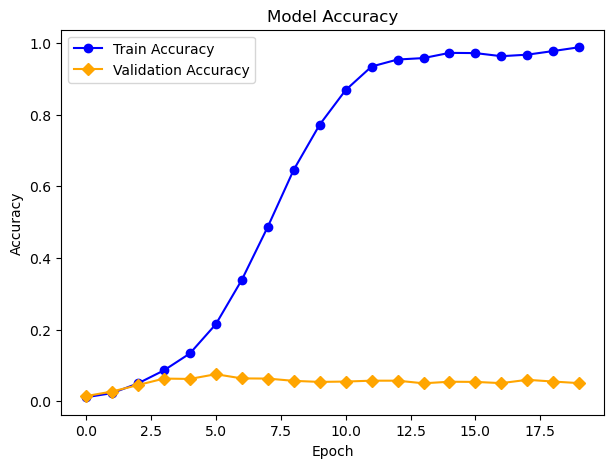

In [22]:
# graph of accuracy of training & validation data
plt.figure(figsize=(7,5))
plt.plot(first.history['accuracy'],label="Train Accuracy",color="blue",marker="o")
plt.plot(first.history['val_accuracy'],label="Validation Accuracy",color="orange",marker="D")
#plt.grid(True)
plt.legend()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [23]:
# Preprocessing test images like the training set
# List all image files in the testing data path
test_image_files = os.listdir(test)

# Specify the image size
image_size = 100  # Adjust to your desired image size

# Preprocess testing data
test_data = np.zeros((len(test_image_files), image_size, image_size, 3), dtype="float32")

for i, img_id in enumerate(test_image_files):
    img_path = os.path.join(test, img_id)
    img2 = Image.open(img_path)
    
    # Resize the image
    img2 = img2.resize((image_size, image_size))

    #normalize pixel values
    image_array_test = np.array(img2)/255
    
    # Convert to array and preprocess
    #img_array = preprocess_input(np.expand_dims(np.array(img), axis=0))
    
    test_data[i] = image_array_test

In [24]:
# Make predictions on the testing data
predictions1 = base_model.predict(test_data)

324/324 [==============================] - 19s 59ms/step


In [25]:
# Evaluate the model on the testing data
evaluation_results = base_model.evaluate(test_data)

# Extract the loss score
loss_score = evaluation_results[0]

# Print the loss score
print(f'Test Loss: {loss_score:.4f}')

324/324 [==============================] - 2s 4ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Test Loss: 0.0000


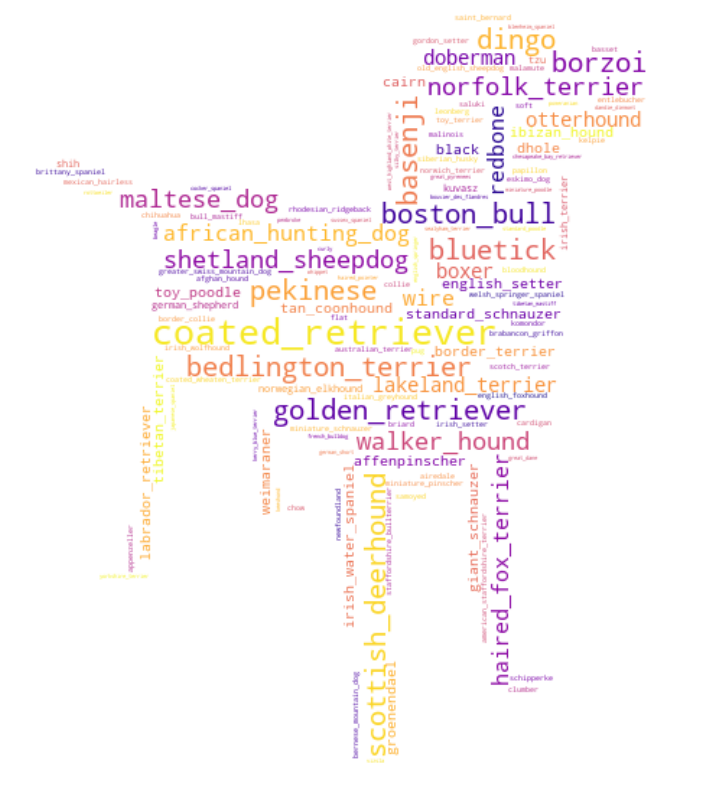

In [26]:
# word cloud of breeds for fun
# join breed names into a single string
text = ' '.join(labels)

mask = np.array(Image.open("../data/dog-silhouette.jpg"))

wordcloud = WordCloud(width=600, height=300, 
                      colormap="plasma", 
                      mask=mask, 
                      background_color='white'
                      ).generate(text)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [27]:
# Save the model to a file
base_model.save('basic_model.h5')

# use to load into another notebook
#from tensorflow.keras.models import load_model

# Load the model from the file
#loaded_model = load_model('basic_model.h5')

c:\Users\kpegg\anaconda3\envs\capstone\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
# increasing the number of epochs
second = base_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=60, batch_size=32)

Epoch 1/60
256/256 [==============================] - 55s 213ms/step - loss: 0.5615 - accuracy: 0.8414 - val_loss: 13.1361 - val_accuracy: 0.0538
Epoch 2/60
256/256 [==============================] - 52s 204ms/step - loss: 0.4154 - accuracy: 0.8865 - val_loss: 14.1078 - val_accuracy: 0.0460
Epoch 3/60
256/256 [==============================] - 50s 197ms/step - loss: 0.1244 - accuracy: 0.9649 - val_loss: 16.0286 - val_accuracy: 0.0543
Epoch 4/60
256/256 [==============================] - 50s 195ms/step - loss: 0.0555 - accuracy: 0.9861 - val_loss: 16.8187 - val_accuracy: 0.0528
Epoch 5/60
256/256 [==============================] - 49s 192ms/step - loss: 0.0636 - accuracy: 0.9845 - val_loss: 18.5439 - val_accuracy: 0.0489
Epoch 6/60
256/256 [==============================] - 48s 189ms/step - loss: 0.1141 - accuracy: 0.9689 - val_loss: 16.7668 - val_accuracy: 0.0494
Epoch 7/60
256/256 [==============================] - 49s 191ms/step - loss: 0.1404 - accuracy: 0.9611 - val_loss: 17.8476 -

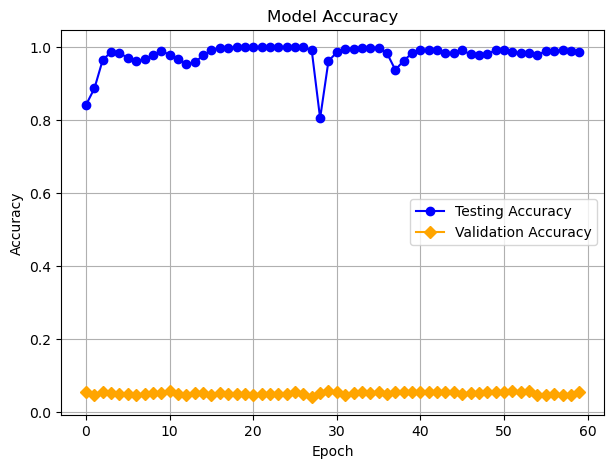

In [29]:
# graph of accuracy of training & validation data
plt.figure(figsize=(7,5))
plt.plot(second.history['accuracy'],label="Testing Accuracy",color="blue",marker="o")
plt.plot(second.history['val_accuracy'],label="Validation Accuracy",color="orange",marker="D")
plt.grid(True)
plt.legend()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [30]:
# Function to preprocess an image
def preprocess_image(image_path, image_size):
    img = Image.open(image_path)
    img = img.resize((image_size, image_size))
    img_array = np.array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Load the 'labels' dataframe
df_labels = pd.read_csv("../data/dog-breed-identification/labels.csv")

# Predict on test images and map predicted class indices to breed names
predicted_breeds = []
for image_filename in os.listdir(test):
    image_path = os.path.join(test, image_filename)
    img_array = preprocess_image(image_path, 100)  # Assuming image size is 100x100
    predictions = base_model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_breed = df_labels.iloc[predicted_class_index]["breed"]
    predicted_breeds.append(predicted_breed)

# Print the predicted breed for each image
for image_filename, predicted_breed in zip(os.listdir(test), predicted_breeds):
    print(f"Image: {image_filename}, Predicted Breed: {predicted_breed}")

1/1 [==============================] - 0s 29ms/step
Image: 000621fb3cbb32d8935728e48679680e.jpg, Predicted Breed: bluetick
Image: 00102ee9d8eb90812350685311fe5890.jpg, Predicted Breed: brittany_spaniel
Image: 0012a730dfa437f5f3613fb75efcd4ce.jpg, Predicted Breed: saluki
Image: 001510bc8570bbeee98c8d80c8a95ec1.jpg, Predicted Breed: bull_mastiff
Image: 001a5f3114548acdefa3d4da05474c2e.jpg, Predicted Breed: english_setter
Image: 00225dcd3e4d2410dd53239f95c0352f.jpg, Predicted Breed: welsh_springer_spaniel
Image: 002c2a3117c2193b4d26400ce431eebd.jpg, Predicted Breed: irish_water_spaniel
Image: 002c58d413a521ae8d1a5daeb35fc803.jpg, Predicted Breed: malamute
Image: 002f80396f1e3db687c5932d7978b196.jpg, Predicted Breed: bedlington_terrier
Image: 0036c6bcec6031be9e62a257b1c3c442.jpg, Predicted Breed: ibizan_hound
Image: 0041940322116ae58c38130f5a6f71f9.jpg, Predicted Breed: standard_schnauzer
Image: 0042d6bf3e5f3700865886db32689436.jpg, Predicted Breed: malinois
Image: 004476c96f575879af4af471

In [31]:
# Create a dataframe with image filenames and predicted breed names
predictions_df = pd.DataFrame({
    "Image Filename": os.listdir(test),
    "Predicted Breed": predicted_breeds
})

predictions_df

Image Filename             Predicted Breed
0      000621fb3cbb32d8935728e48679680e.jpg                    bluetick
1      00102ee9d8eb90812350685311fe5890.jpg            brittany_spaniel
2      0012a730dfa437f5f3613fb75efcd4ce.jpg                      saluki
3      001510bc8570bbeee98c8d80c8a95ec1.jpg                bull_mastiff
4      001a5f3114548acdefa3d4da05474c2e.jpg              english_setter
...                                     ...                         ...
10352  ffeda8623d4eee33c6d1156a2ecbfcf8.jpg  greater_swiss_mountain_dog
10353  fff1ec9e6e413275984966f745a313b0.jpg             giant_schnauzer
10354  fff74b59b758bbbf13a5793182a9bbe4.jpg                 appenzeller
10355  fff7d50d848e8014ac1e9172dc6762a3.jpg                      kelpie
10356  fffbff22c1f51e3dc80c4bf04089545b.jpg                    malamute

[10357 rows x 2 columns]

In [32]:
predicted_results = []
for image_filename in os.listdir(test):
    image_path = os.path.join(test, image_filename)
    img_array = preprocess_image(image_path, 100)  # Assuming image size is 100x100
    predictions = base_model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    #predicted_breed = label_encoder.inverse_transform([predicted_class_index])[0]
    predicted_breed = df_labels.iloc[predicted_class_index]["breed"]
    predicted_probability = predictions[0][predicted_class_index]
    predicted_results.append((image_filename, predicted_breed, predicted_probability))

# Create a dataframe from the predicted results
pred_prob_df = pd.DataFrame(predicted_results, columns=["Image Filename", "Predicted Breed", "Predicted Probability"])

pred_prob_df

1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


Image Filename             Predicted Breed  \
0      000621fb3cbb32d8935728e48679680e.jpg                    bluetick   
1      00102ee9d8eb90812350685311fe5890.jpg            brittany_spaniel   
2      0012a730dfa437f5f3613fb75efcd4ce.jpg                      saluki   
3      001510bc8570bbeee98c8d80c8a95ec1.jpg                bull_mastiff   
4      001a5f3114548acdefa3d4da05474c2e.jpg              english_setter   
...                                     ...                         ...   
10352  ffeda8623d4eee33c6d1156a2ecbfcf8.jpg  greater_swiss_mountain_dog   
10353  fff1ec9e6e413275984966f745a313b0.jpg             giant_schnauzer   
10354  fff74b59b758bbbf13a5793182a9bbe4.jpg                 appenzeller   
10355  fff7d50d848e8014ac1e9172dc6762a3.jpg                      kelpie   
10356  fffbff22c1f51e3dc80c4bf04089545b.jpg                    malamute   

       Predicted Probability  
0                   0.383785  
1                   0.999946  
2                   0.714134  
3                   0.540077  
4                   0.390350  
...                      ...  
10352               1.000000  
10353               0.787224  
10354               0.997646  
10355               0.701341  
10356               0.998066  

[10357 rows x 3 columns]

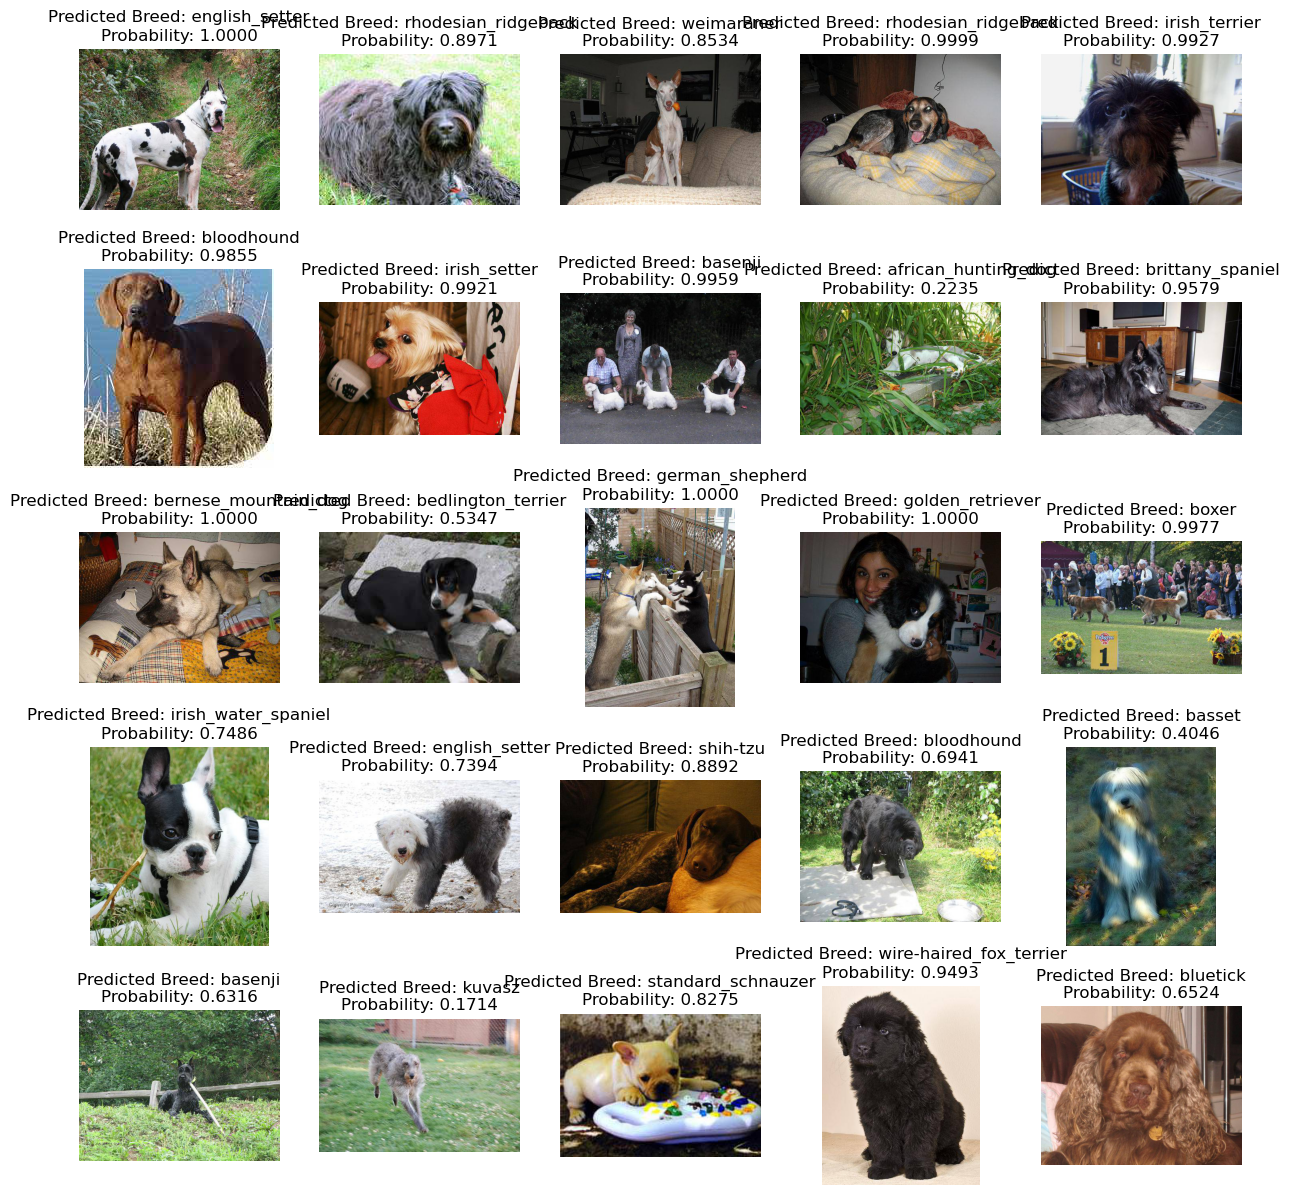

In [33]:
import random

num_images_to_display = 25
random_indices = random.sample(range(len(predictions_df)), num_images_to_display)

# Plot the images with their predicted breed names and probabilities
plt.figure(figsize=(15, 15))
for i, idx in enumerate(random_indices):
    image_filename = pred_prob_df.loc[idx, "Image Filename"]
    predicted_breed = pred_prob_df.loc[idx, "Predicted Breed"]
    predicted_probability = pred_prob_df.loc[idx, "Predicted Probability"]
    
    # Load and display the image
    image_path = os.path.join(test, image_filename)
    img = Image.open(image_path)
    
    row = i // 5
    col = i % 5
    
    plt.subplot(5, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Predicted Breed: {predicted_breed}\nProbability: {predicted_probability:.4f}")
    plt.axis("off")

plt.show()

1/1 [==============================] - 0s 95ms/step


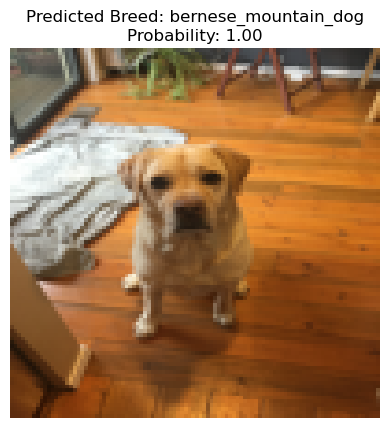

In [36]:
# Function to preprocess the image
def preprocess_image(image_path, image_size):
    img = Image.open(image_path)
    img = img.resize((image_size, image_size))
    img_array = np.array(img) #/ 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img, img_array

# Path to the locally saved image
image_path = r"C:\Users\kpegg\Documents\Flatiron\Projects\05_Nose_Knows\data\IMG_6753.jpg"

# Preprocess the image
img, preprocessed_img = preprocess_image(image_path, 100)  # Assuming image size is 100x100

# Rotate the image
img = img.rotate(270, expand=True)

# Use the pre-trained base_model to predict
predictions = base_model.predict(preprocessed_img)
predicted_class_index = np.argmax(predictions)
predicted_breed = df_labels.iloc[predicted_class_index]["breed"]
predicted_probability = predictions[0][predicted_class_index]  # Probability of the predicted class

# Display the image
plt.imshow(img)
plt.title(f"Predicted Breed: {predicted_breed}\nProbability: {predicted_probability:.2f}")
plt.axis("off")
plt.show()